<a href="https://colab.research.google.com/github/rixwan-khan/Credit_Card_Fraud_Detection/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # **Credit Card Fraud Detection**

In this project, we focus on building a Credit Card Fraud Detection system using historical transaction data. The dataset labels each transaction as either:

Fraudulent (1) – Transactions identified as fraud.\
Normal (0) – Legitimate transactions.

\
**Objective:**
Develop a model that can accurately identify fraudulent transactions while minimizing false negatives, thereby enabling timely and reliable fraud detection.


### **0. Importing Libraries**

In [4]:
# Data Handling Libraries
import numpy as np
import pandas as pd
from datetime import datetime

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools

# Machine Learning & Modeling
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm

# Gradient boosting & Advance models
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

In [5]:
!pip install catboost

##**1. Loading Dataset from Kaggle**

In [6]:
!pip install kaggle

# Upload kaggle.json from your Kaggle account
from google.colab import files
files.upload()   # upload kaggle.json

# Setup credentials
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
os.chmod("/root/.kaggle/kaggle.json", 600)

# Download dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud

# Unzip dataset
!unzip creditcardfraud.zip

# Load into pandas
import pandas as pd
df = pd.read_csv("creditcard.csv")



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.04GB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## **2. Data Exploration (EDA)**

In this section, exploring the dataset to understand its structure, and class imbalance. Visualizations and summary statistics will help identify patterns, outliers, and insights for building an effective fraud detection model.

###**2.1 Dataset Structure & Summary**

In [8]:
df.shape

(284807, 31)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The dataset contains 284,807 transactions with 31 columns, including anonymized features, transaction amount, time, and a target class indicating fraud (1) or genuine (0).

### **2.2 Statistical Summary**

In [10]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The transaction amounts range from \$0 to \$25,691, with most transactions below \$100 (median \$22).

#### **2.2.1 Transaction Amount based on Class**

In [11]:
# Transaction class:  0=Normal, 1=Fraud

normal = df[df['Class']==0]
fraud = df[df['Class']==1]

In [12]:
# statistical summary for the Amount column of non-fraudulent transactions
normal.Amount.describe()

,Amount
count,284315.000000
mean,88.291022
std,250.105092
min,0.000000
25%,5.650000
50%,22.000000
75%,77.050000
max,25691.160000


In [13]:
# statistical summary for the Amount column of fraudulent transactions
fraud.Amount.describe()

,Amount
count,492.000000
mean,122.211321
std,256.683288
min,0.000000
25%,1.000000
50%,9.250000
75%,105.890000
max,2125.870000


### **2.3 Class Distribution (%)**

In [14]:
dist = df['Class'].value_counts(normalize=True)*100
dist

,proportion
Class,
0,99.827251
1,0.172749


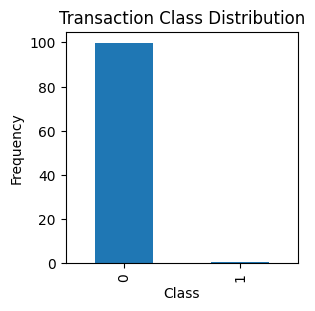

In [15]:
plt.figure(figsize=(3,3))
dist.plot(kind = 'bar')
plt.title("Transaction Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency");

The dataset is highly imbalanced, with only a tiny fraction (0.17%) of transactions labeled as fraudulent and 99.8% are Normal.

### **2.4 Missing Values**

In [16]:
df.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


By checking missing values it shows that there is no missing values in dataset.

### **2.5 Checking Duplicate:**

In [17]:
dup = df.duplicated().sum()
print('Duplicated rows:',dup)

Duplicated rows: 1081


#### ***2.5.1 Removing Duplicate Rows:***

In [18]:
df_copy = df.copy()

In [19]:
df = df.drop_duplicates()

### **2.6 Correlation Analysis**

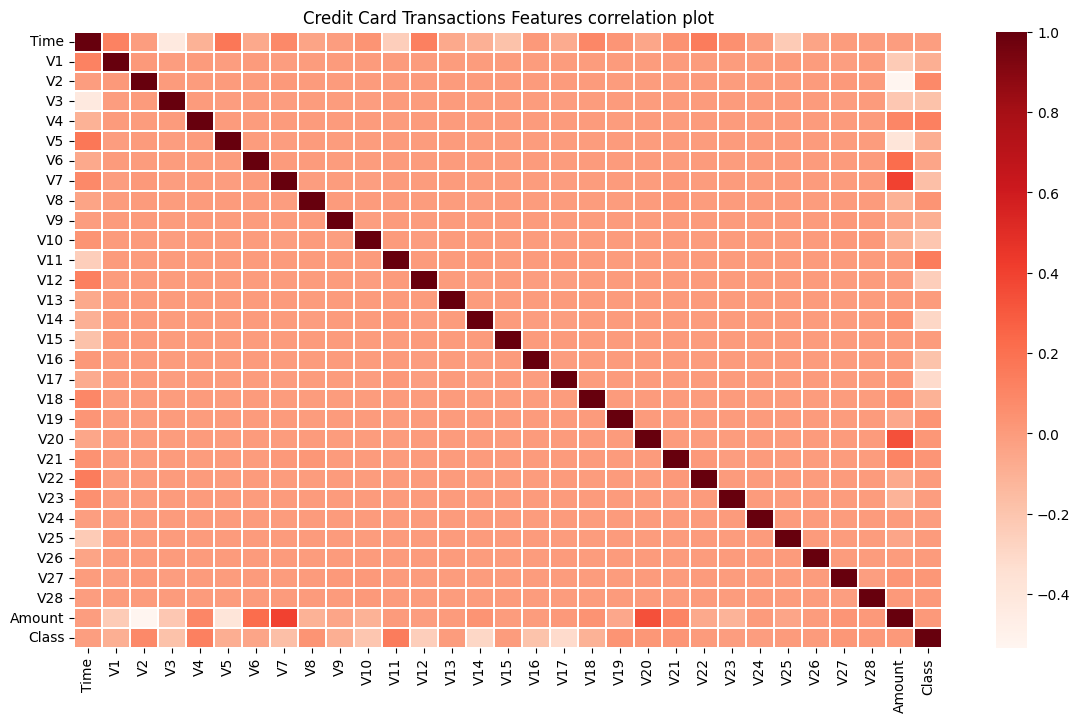

In [29]:
plt.figure(figsize=(14,8))
plt.title('Credit Card Transactions Features correlation plot')
corr = df.corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
    linewidths=.1,
    cmap='Reds'
)

plt.show();

**Amount vs. Class:** The correlation between the transaction amount and fraud (Class) is very weak (close to 0). This means the size of a transaction alone does not strongly indicate whether it is fraudulent.

**Time vs. Class:** The correlation between the transaction time and fraud is also very weak. This suggests that fraudulent transactions can occur at any time and are not concentrated at specific times in the dataset.